In [1]:
# =========================================
# 0) Mount Google Drive & set output folder
# =========================================
from google.colab import drive
from pathlib import Path

# Mount Drive
drive.mount('/content/drive')

# Define output path inside Drive
OUT_DIR = Path("/content/drive/MyDrive/student_project_outputs")
OUT_DIR.mkdir(exist_ok=True, parents=True)

print(f"✅ All results will be saved in: {OUT_DIR}")


Mounted at /content/drive
✅ All results will be saved in: /content/drive/MyDrive/student_project_outputs


**Imports, Configuration, and Directories**

In [6]:
# =========================================
# 1) Imports, Config, Globals
# =========================================
import os, math, random, io, zipfile, urllib.request
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, f1_score, precision_score, recall_score,
                             roc_auc_score, confusion_matrix, classification_report)
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from imblearn.over_sampling import SMOTE

import shap, optuna, plotly.express as px, plotly.graph_objects as go

# Use the same OUT_DIR you defined earlier
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

sns.set(context="notebook", style="whitegrid")
print(f"Output directory: {OUT_DIR}")


Output directory: /content/drive/MyDrive/student_project_outputs


**load and Combine UCI Dataset**

In [7]:
# ================================
# 2) Load UCI Student Performance Data
# ================================
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

zip_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"

if not (DATA_DIR/"student-mat.csv").exists():
    print("Downloading dataset...")
    with urllib.request.urlopen(zip_url) as resp:
        z = zipfile.ZipFile(io.BytesIO(resp.read()))
        z.extractall(DATA_DIR)

# load and merge
def load_subject(sub):
    df = pd.read_csv(DATA_DIR / f"student-{sub}.csv", sep=";")
    df["subject"] = sub
    return df

df = pd.concat([load_subject("mat"), load_subject("por")], ignore_index=True)
print(f"Loaded {df.shape[0]} records, {df.shape[1]} columns.")
df.head()


Loaded 1044 records, 34 columns.


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,mat
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,mat
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,mat
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,mat
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,mat


**Exploratory Data Analysis (EDA)**

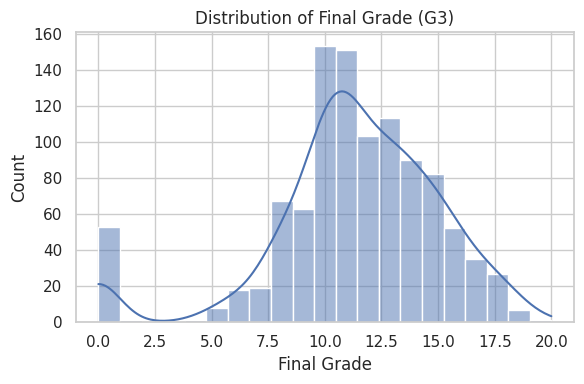

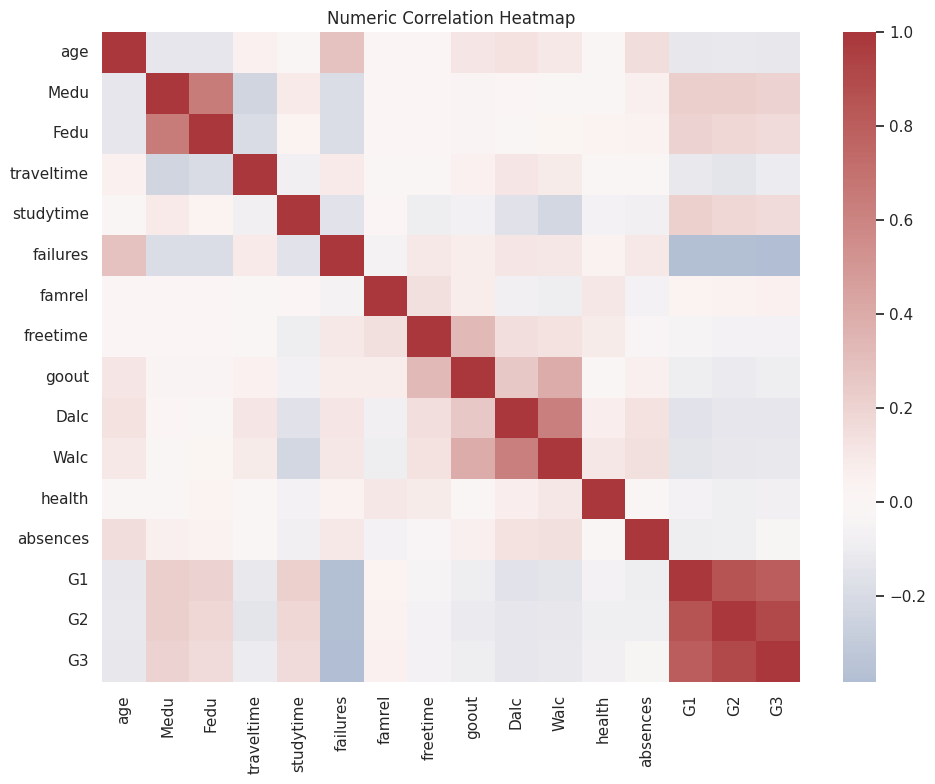

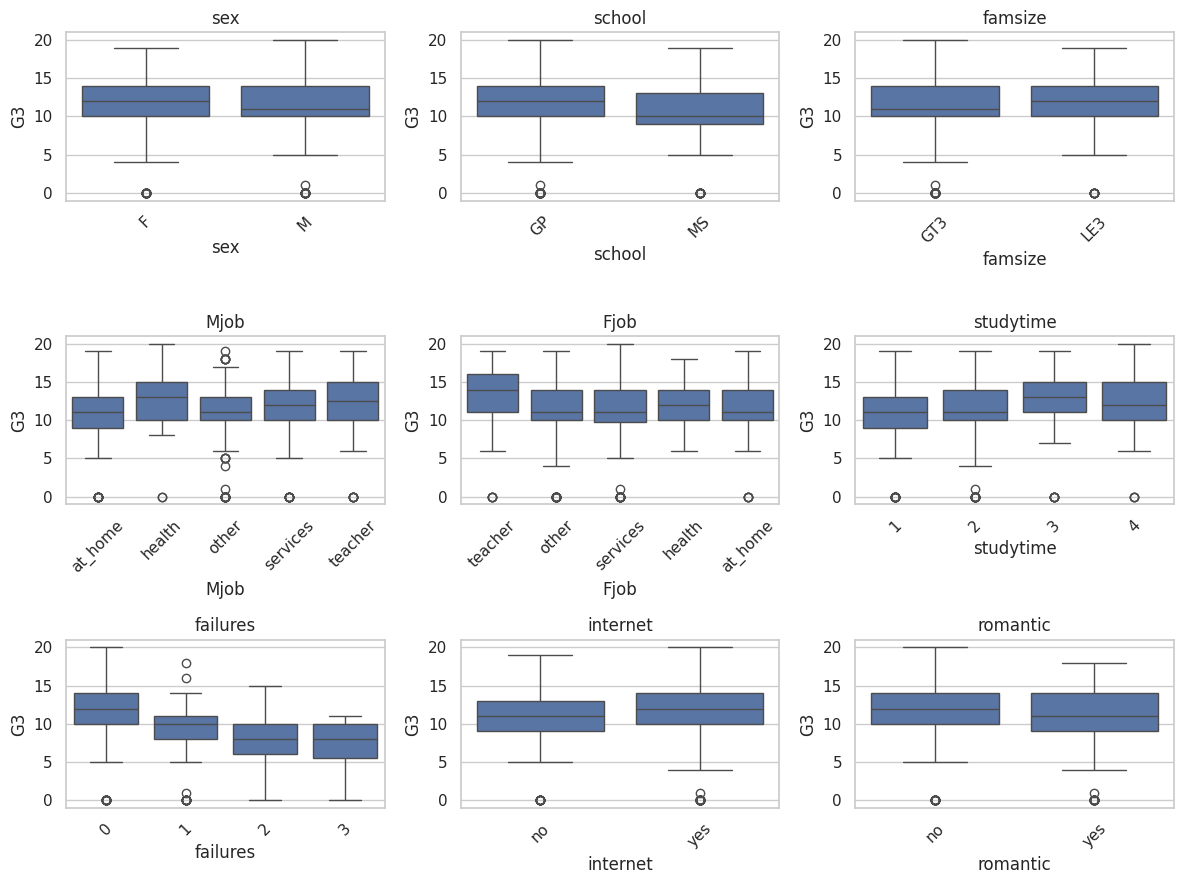

In [8]:
# ================================
# 3) Exploratory Data Analysis
# ================================

# Grade distribution
plt.figure(figsize=(6,4))
sns.histplot(df["G3"], bins=21, kde=True)
plt.title("Distribution of Final Grade (G3)")
plt.xlabel("Final Grade")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(OUT_DIR/"grade_distribution.png", dpi=300)
plt.show()

# Correlation heatmap (numeric)
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="vlag", center=0)
plt.title("Numeric Correlation Heatmap")
plt.tight_layout()
plt.savefig(OUT_DIR/"correlation_heatmap.png", dpi=300)
plt.show()

# Boxplots for key categorical features vs G3
top_cats = ["sex","school","famsize","Mjob","Fjob","studytime","failures","internet","romantic"]
ncols = 3
nrows = math.ceil(len(top_cats)/ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
axes = axes.flatten()
for i, col in enumerate(top_cats):
    sns.boxplot(data=df, x=col, y="G3", ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_title(col)
plt.tight_layout()
plt.savefig(OUT_DIR/"categorical_boxplots.png", dpi=300)
plt.show()


**Helper Functions and Preprocessing**

In [9]:
# ================================
# 4) Targets and Preprocessing
# ================================
TARGET = "G3"
LEAKY = ["G1", "G2"]

def make_targets(frame):
    y_reg = frame[TARGET]
    y_bin = (frame[TARGET] >= 10).astype(int)
    y_band = pd.cut(frame[TARGET], [-1,9,14,20], labels=["low","mid","high"]).astype(str)
    return y_reg, y_bin, y_band

def build_preprocessor(X, scale_numeric=False):
    cats = X.select_dtypes(include=["object"]).columns.tolist()
    nums = X.select_dtypes(exclude=["object"]).columns.tolist()
    transformers = []
    if cats:
        transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), cats))
    if nums:
        if scale_numeric:
            transformers.append(("num", Pipeline([
                ("imp", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())
            ]), nums))
        else:
            transformers.append(("num", SimpleImputer(strategy="median"), nums))
    return ColumnTransformer(transformers)

def reg_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "R2": r2_score(y_true, y_pred)
    }

def bin_metrics(y_true, y_pred, y_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "AUC": roc_auc_score(y_true, y_proba)
    }


In [22]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


**Regression: With vs Without Leakage**

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 182
[LightGBM] [Info] Number of data points in the train set: 835, number of used features: 58
[LightGBM] [Info] Start training from score 11.413174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

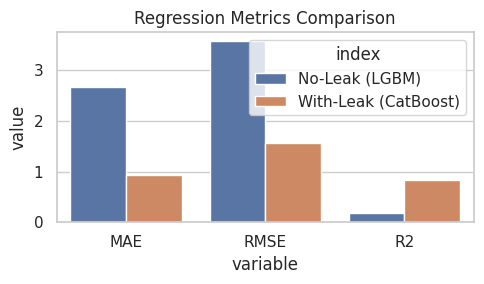

In [23]:
# ================================
# 5) Regression (No-Leak vs With-Leak)
# ================================

from sklearn.pipeline import Pipeline

# --- Helper: split data for regression ---
def split_data(frame, drop_leaky=True):
    X = frame.copy()
    y_reg, y_bin, y_band = make_targets(X)
    X = X.drop(columns=[TARGET])
    if drop_leaky:
        X = X.drop(columns=[c for c in LEAKY if c in X.columns])
    return train_test_split(X, y_reg, test_size=0.2, random_state=RANDOM_STATE)

# --- Helper: regression metrics (safe for all sklearn versions) ---
def reg_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)     # some sklearn versions lack squared=False
    rmse = np.sqrt(mse)
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse,
        "R2": r2_score(y_true, y_pred)
    }

# --- 1) No-Leak Regression: LightGBM ---
X_tr, X_te, y_tr, y_te = split_data(df, drop_leaky=True)

pipe_reg_noleak = Pipeline([
    ("pre", build_preprocessor(X_tr)),
    ("model", LGBMRegressor(random_state=RANDOM_STATE, n_estimators=300))
])

pipe_reg_noleak.fit(X_tr, y_tr)
pred_no = pipe_reg_noleak.predict(X_te)
metrics_no = reg_metrics(y_te, pred_no)
print("No-Leakage results:", metrics_no)

# --- 2) With-Leak Regression: CatBoost ---
X_trL, X_teL, y_trL, y_teL = split_data(df, drop_leaky=False)

pipe_reg_leak = Pipeline([
    ("pre", build_preprocessor(X_trL)),
    ("model", CatBoostRegressor(random_state=RANDOM_STATE, verbose=False))
])

pipe_reg_leak.fit(X_trL, y_trL)
pred_leak = pipe_reg_leak.predict(X_teL)
metrics_leak = reg_metrics(y_teL, pred_leak)
print("With-Leakage results:", metrics_leak)

# --- 3) Combine and Save Results ---
reg_results = pd.DataFrame(
    [metrics_no, metrics_leak],
    index=["No-Leak (LGBM)", "With-Leak (CatBoost)"]
)

csv_path = OUT_DIR / "regression_results.csv"
reg_results.to_csv(csv_path)
print(f"\n✅ Regression comparison table saved to: {csv_path}")

# --- Optional: quick visualization ---
plt.figure(figsize=(5,3))
sns.barplot(data=reg_results.reset_index().melt(id_vars="index"),
            x="variable", y="value", hue="index")
plt.title("Regression Metrics Comparison")
plt.tight_layout()
plt.savefig(OUT_DIR / "regression_metrics_comparison.png", dpi=300)
plt.show()


**Binary Classification (Pass/Fail)**

{'Accuracy': 0.7751196172248804, 'Precision': 0.8222222222222222, 'Recall': 0.9079754601226994, 'F1': 0.8629737609329446, 'AUC': np.float64(0.7476660442784743)}


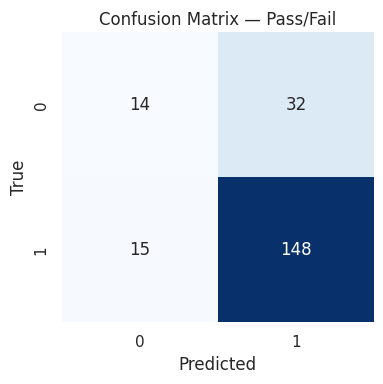

In [24]:
# ================================
# 6) Binary Classification (Pass/Fail)
# ================================
y_reg, y_bin, _ = make_targets(df)
X = df.drop(columns=[TARGET] + LEAKY)  # no leakage
X_tr, X_te, y_tr, y_te = train_test_split(X, y_bin, stratify=y_bin,
                                          test_size=0.2, random_state=RANDOM_STATE)

pipe_bin = Pipeline([
    ("pre", build_preprocessor(X_tr)),
    ("model", XGBClassifier(random_state=RANDOM_STATE, eval_metric="logloss", use_label_encoder=False))
])
pipe_bin.fit(X_tr, y_tr)
pred = pipe_bin.predict(X_te)
proba = pipe_bin.predict_proba(X_te)[:,1]
bin_res = bin_metrics(y_te, pred, proba)
print(bin_res)

pd.DataFrame([bin_res]).to_csv(OUT_DIR/"binary_results.csv", index=False)

# Confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix(y_te, pred), annot=True, fmt="d", cbar=False, cmap="Blues")
plt.title("Confusion Matrix — Pass/Fail")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.savefig(OUT_DIR/"confusion_matrix_passfail.png", dpi=300)
plt.show()


**Three-Band Classification**

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 182
[LightGBM] [Info] Number of data points in the train set: 835, number of used features: 58
[LightGBM] [Info] Start training from score -1.633682
[LightGBM] [Info] Start training from score -1.512496
[LightGBM] [Info] Start training from score -0.537116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

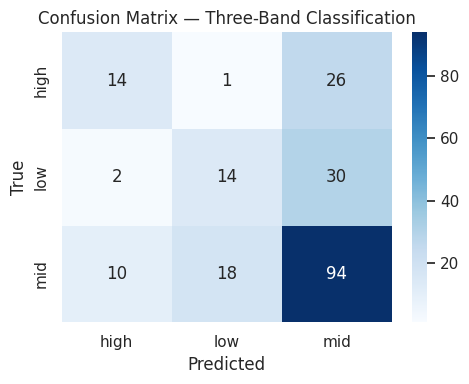

In [25]:
# ================================
# 7) Three-Band Classification (Low/Mid/High)
# ================================
_, _, y_band = make_targets(df)
Xb = df.drop(columns=[TARGET] + LEAKY)
le = LabelEncoder()
y_enc = le.fit_transform(y_band)

X_tr, X_te, y_tr, y_te = train_test_split(Xb, y_enc, stratify=y_enc, test_size=0.2, random_state=RANDOM_STATE)
pipe_band = Pipeline([
    ("pre", build_preprocessor(X_tr)),
    ("model", LGBMClassifier(random_state=RANDOM_STATE, n_estimators=300))
])
pipe_band.fit(X_tr, y_tr)
pred_band = pipe_band.predict(X_te)
macro_f1 = f1_score(y_te, pred_band, average="macro")
print("Three-Band Macro F1:", macro_f1)

# Confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_te, pred_band), annot=True, fmt='d', cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix — Three-Band Classification")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.savefig(OUT_DIR/"confusion_matrix_bands.png", dpi=300)
plt.show()


**Feature Importance & SHAP**

Computing permutation importance...
✅ Saved top-15 permutation importances → /content/drive/MyDrive/student_project_outputs/feature_importance.csv


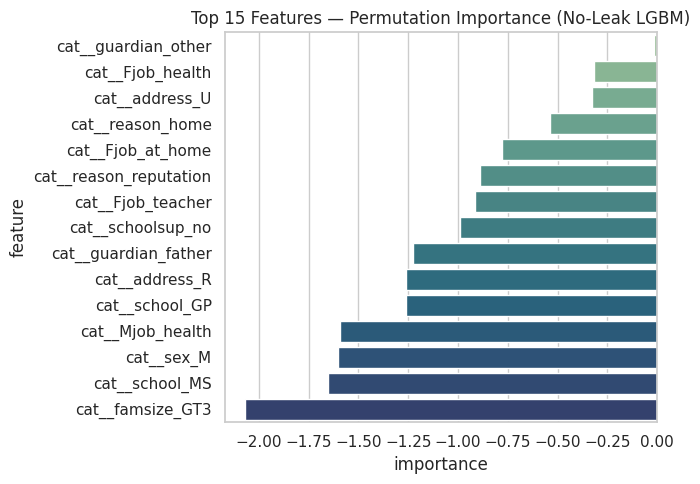

Computing SHAP summary plot (this may take a minute)...


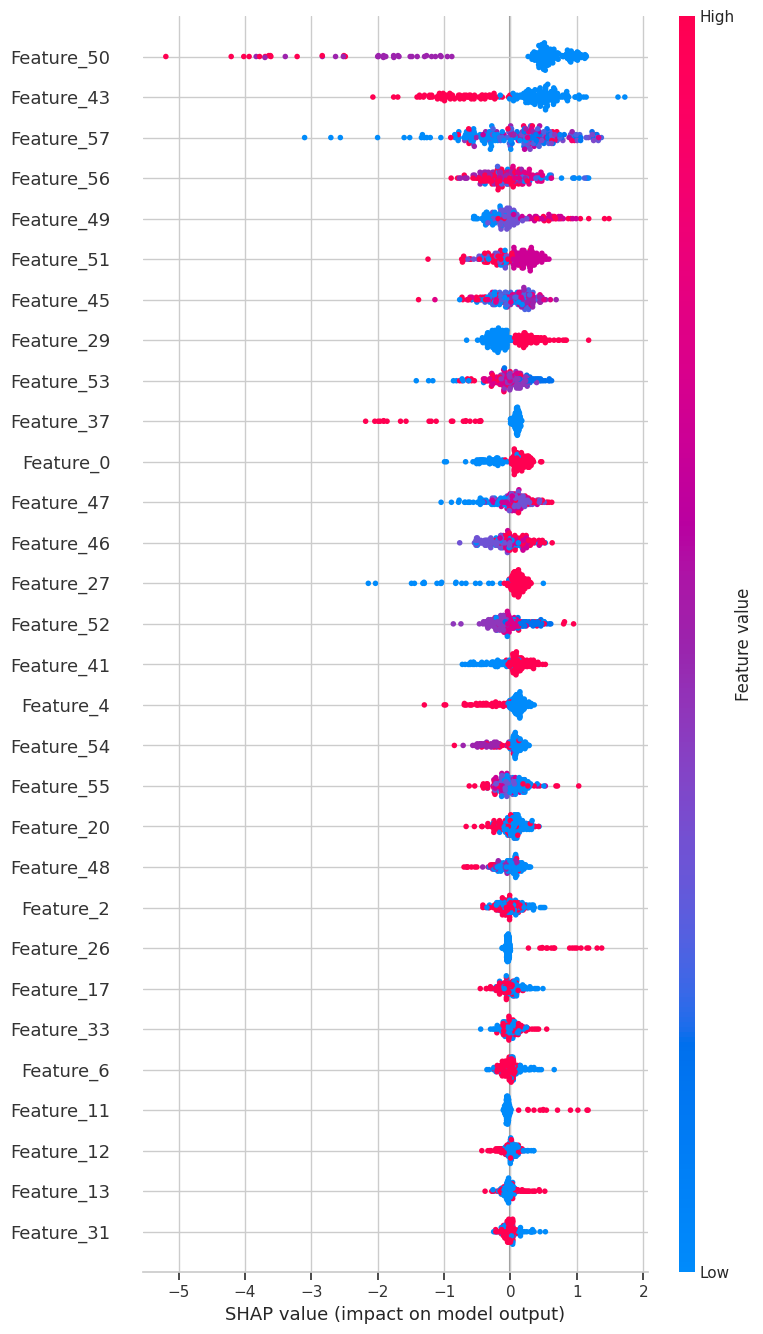

✅ SHAP summary plot saved: /content/drive/MyDrive/student_project_outputs/shap_summary.png


In [28]:
# ================================
# 8) Feature Importance (Permutation + SHAP)
# ================================
import shap
from sklearn.inspection import permutation_importance

print("Computing permutation importance...")

# --- Permutation importance ---
pre = pipe_reg_noleak.named_steps["pre"]

# Try to get all transformed feature names safely
try:
    feat_names = pre.get_feature_names_out()
except Exception:
    feat_names = []
    for name, trans, cols in pre.transformers_:
        if hasattr(trans, 'get_feature_names_out'):
            fn = trans.get_feature_names_out(cols)
            feat_names.extend(fn)
        else:
            feat_names.extend(cols)

# Compute permutation importance
result = permutation_importance(
    pipe_reg_noleak, X_te, y_te, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
)

# Align shapes safely
min_len = min(len(feat_names), len(result.importances_mean))
feat_names = feat_names[:min_len]
importances = result.importances_mean[:min_len]

imp_df = (
    pd.DataFrame({"feature": feat_names, "importance": importances})
    .sort_values("importance", ascending=False)
    .head(15)
)
imp_df.to_csv(OUT_DIR / "feature_importance.csv", index=False)
print(f"✅ Saved top-15 permutation importances → {OUT_DIR/'feature_importance.csv'}")

plt.figure(figsize=(7, 5))
sns.barplot(data=imp_df, y="feature", x="importance", palette="crest")
plt.title("Top 15 Features — Permutation Importance (No-Leak LGBM)")
plt.tight_layout()
plt.savefig(OUT_DIR / "feature_importance_bar.png", dpi=300)
plt.show()

# --- SHAP analysis ---
print("Computing SHAP summary plot (this may take a minute)...")

# Transform test data through preprocessor
X_enc = pre.transform(X_te)
if hasattr(X_enc, "toarray"):
    X_enc = X_enc.toarray()

# Fix: generate new feature names matching encoded data shape
n_features = X_enc.shape[1]
if len(feat_names) != n_features:
    feat_names = [f"Feature_{i}" for i in range(n_features)]

# Compute SHAP values
model = pipe_reg_noleak.named_steps["model"]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_enc)

# Limit features for display
display_limit = min(30, len(feat_names))

# SHAP summary plot
plt.figure()
shap.summary_plot(
    shap_values,
    X_enc,
    feature_names=feat_names,
    show=False,
    max_display=display_limit
)
plt.tight_layout()
plt.savefig(OUT_DIR / "shap_summary.png", dpi=300)
plt.show()

print("✅ SHAP summary plot saved:", OUT_DIR / "shap_summary.png")


**Residual Diagnostics**

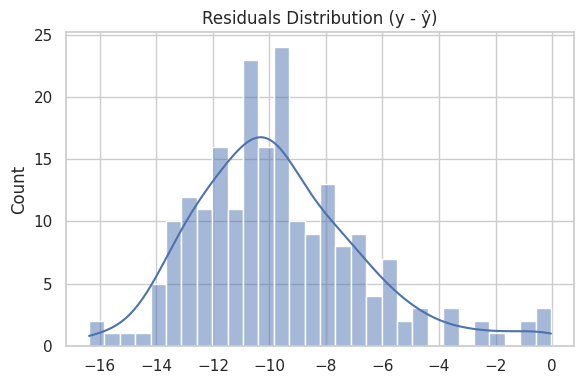

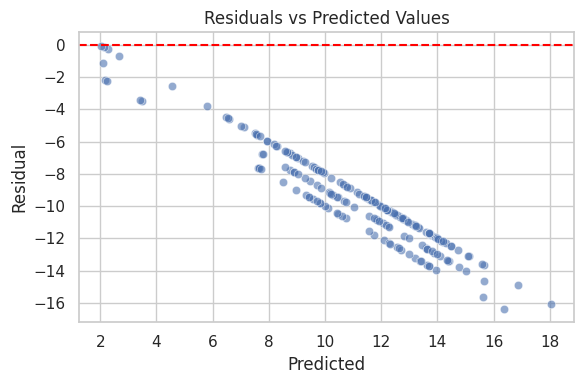

In [29]:
# ================================
# 9) Residual Diagnostics (No-Leak Regression)
# ================================
residuals = y_te - pred_no
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residuals Distribution (y - ŷ)")
plt.tight_layout()
plt.savefig(OUT_DIR/"residuals_hist.png", dpi=300)
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x=pred_no, y=residuals, alpha=0.6)
plt.axhline(0, color="red", ls="--")
plt.xlabel("Predicted"); plt.ylabel("Residual")
plt.title("Residuals vs Predicted Values")
plt.tight_layout()
plt.savefig(OUT_DIR/"residuals_scatter.png", dpi=300)
plt.show()


**Subject-Specific Models**

In [30]:
# ================================
# 10) Subject-Specific Regression Models
# ================================
subj_metrics = {}
for subj in ["mat","por"]:
    df_s = df[df["subject"]==subj]
    X_tr, X_te, y_tr, y_te = split_data(df_s, drop_leaky=True)
    pipe = Pipeline([
        ("pre", build_preprocessor(X_tr)),
        ("model", LGBMRegressor(random_state=RANDOM_STATE, n_estimators=300))
    ])
    pipe.fit(X_tr, y_tr)
    pred = pipe.predict(X_te)
    subj_metrics[subj] = reg_metrics(y_te, pred)

subj_df = pd.DataFrame(subj_metrics).T
subj_df.to_csv(OUT_DIR/"subject_metrics.csv")
print(subj_df)
print("\nSaved: subject_metrics.csv")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 167
[LightGBM] [Info] Number of data points in the train set: 316, number of used features: 52
[LightGBM] [Info] Start training from score 10.325949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -